In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datasets.tensor_storage import TensorStorage
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP
import ncvis
import time
import os

/home/jovyan/.mlspace/envs/dim3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dim_experiment_id = "deepinfomax_20241218_052013"
ae_experiment_id = "autoencoder_20241218_054318"

In [3]:
dim_store = TensorStorage(f"storages/{dim_experiment_id}")
ae_store = TensorStorage(f"storages/{ae_experiment_id}")

In [4]:
def save_high_quality_plots(reduced_embeddings, subset_labels, methods, explained_var=None, output_dir='viz_results', dpi=300):
    """Save individual high-quality plots for each method."""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # CIFAR-10 class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    
    # Use a colorful and visually appealing palette
    palette = sns.color_palette('husl', n_colors=len(class_names))
    
    for method in methods:
        # Create new figure for each method
        plt.figure(figsize=(10, 8))
        embeddings_2d = reduced_embeddings[method]
        
        # Plot each class
        for label in range(len(class_names)):
            mask = subset_labels == label
            plt.scatter(
                embeddings_2d[mask, 0],
                embeddings_2d[mask, 1],
                c=[palette[label]],
                label=class_names[label],
                alpha=0.7,
                s=60,  # Slightly larger points for individual plots
                rasterized=True
            )
        
        # Customize the plot
        title = method.upper()
        if method == 'pca' and explained_var is not None:
            var_1, var_2 = explained_var[method]
            title += f'\nExplained Variance: ({var_1:.1%}, {var_2:.1%})'
            
        plt.title(title, fontsize=16, pad=20)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        # Add legend
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            fontsize=12,
            markerscale=1.5
        )
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(
            os.path.join(output_dir, f'{method}_embedding.png'),
            dpi=dpi,
            bbox_inches='tight',
            facecolor='white'
        )
        plt.close()

In [5]:

def reduce_and_plot_embeddings(embeddings, metadata_df, split='train', methods=None, n_samples=1000, seed=42, save_dir='viz_results'):
    """Apply different dimensionality reduction methods and plot results on a subset."""
    if methods is None:
        methods = ['pca', 'tsne', 'umap', 'ncvis']  # Added PCA to default methods
        
    # CIFAR-10 class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    
    # Filter by split
    split_mask = metadata_df['split'] == split
    split_embeddings = embeddings[split_mask]
    split_labels = metadata_df[split_mask]['label'].values
    
    # Take stratified random sample
    np.random.seed(seed)
    samples_per_class = n_samples // len(class_names)
    sampled_indices = []
    
    for label in range(len(class_names)):
        label_indices = np.where(split_labels == label)[0]
        if len(label_indices) > samples_per_class:
            sampled_indices.extend(
                np.random.choice(label_indices, samples_per_class, replace=False)
            )
        else:
            sampled_indices.extend(label_indices)
    
    # Get subset of data
    subset_embeddings = split_embeddings[sampled_indices]
    subset_labels = split_labels[sampled_indices]
    
    # Scale the features
    scaler = StandardScaler()
    subset_embeddings = scaler.fit_transform(subset_embeddings)
    
    # Dictionary to store reduced embeddings and explained variance for PCA
    reduced_embeddings = {}
    times = {}
    explained_var = {}
    
    # Apply each method
    for method in methods:
        print(f"\nApplying {method.upper()}...")
        start_time = time.time()
        
        if method == 'pca':
            reducer = PCA(n_components=2, random_state=42)
            reduced_embeddings[method] = reducer.fit_transform(subset_embeddings)
            explained_var[method] = reducer.explained_variance_ratio_
        elif method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
            reduced_embeddings[method] = reducer.fit_transform(subset_embeddings)
        elif method == 'umap':
            reducer = UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.3)
            reduced_embeddings[method] = reducer.fit_transform(subset_embeddings)
        elif method == 'ncvis':
            reducer = ncvis.NCVis(n_neighbors=30)
            reduced_embeddings[method] = reducer.fit_transform(subset_embeddings)
            
        times[method] = time.time() - start_time
        print(f"{method.upper()} took {times[method]:.2f} seconds")
        
    save_high_quality_plots(
        reduced_embeddings=reduced_embeddings,
        subset_labels=subset_labels,
        methods=methods,
        explained_var=explained_var,
        output_dir=save_dir,
        dpi=300
    )
    
    # Plotting
    n_methods = len(methods)
    fig = plt.figure(figsize=(6*n_methods, 5))
    gs = fig.add_gridspec(1, n_methods + 1, width_ratios=[1]*n_methods + [0.2])
    axes = [fig.add_subplot(gs[0, i]) for i in range(n_methods)]
    
    # Use a colorful and visually appealing palette
    palette = sns.color_palette('husl', n_colors=len(class_names))
    
    for ax, method in zip(axes, methods):
        embeddings_2d = reduced_embeddings[method]
        
        # Plot each class
        for label in range(len(class_names)):
            mask = subset_labels == label
            ax.scatter(
                embeddings_2d[mask, 0],
                embeddings_2d[mask, 1],
                c=[palette[label]],
                label=class_names[label],
                alpha=0.7,
                s=40,
                rasterized=True
            )
        
        # Customize the plot
        title = method.upper()
        if method == 'pca':
            var_1, var_2 = explained_var[method]
            title += f'\nVar: ({var_1:.1%}, {var_2:.1%})'
            
        ax.set_title(title, fontsize=14, pad=10)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add legend
    legend_ax = fig.add_subplot(gs[0, -1])
    legend_ax.axis('off')
    
    # Create legend handles
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=palette[i], label=class_names[i],
                                markersize=8)
                      for i in range(len(class_names))]
    legend_ax.legend(handles=legend_elements, loc='center left', fontsize=10)
    
    plt.tight_layout()
    
    return fig, reduced_embeddings, times, subset_embeddings, subset_labels

In [6]:
def load_embeddings_and_metadata(store):
    metadata_df = store.load_metadata_table()
    
    # Load all embeddings into memory
    embeddings = []
    for i in tqdm(range(len(store)), desc="Loading embeddings"):
        embeddings.append(store[i])
    
    return np.array(embeddings), metadata_df

In [7]:
dim_embeddings, dim_metadata_df = load_embeddings_and_metadata(dim_store)

Loading embeddings: 100%|██████████| 54912/54912 [00:00<00:00, 297368.97it/s]


In [8]:
ae_embeddings, ae_metadata_df = load_embeddings_and_metadata(ae_store)

Loading embeddings: 100%|██████████| 54912/54912 [00:00<00:00, 294667.75it/s]


Applying dimensionality reduction to DeepInfoMax embeddings...

Applying PCA...
PCA took 0.00 seconds

Applying TSNE...
TSNE took 4.64 seconds

Applying UMAP...


/home/jovyan/.mlspace/envs/dim3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/.mlspace/envs/dim3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP took 10.05 seconds

Applying NCVIS...
NCVIS took 28.31 seconds


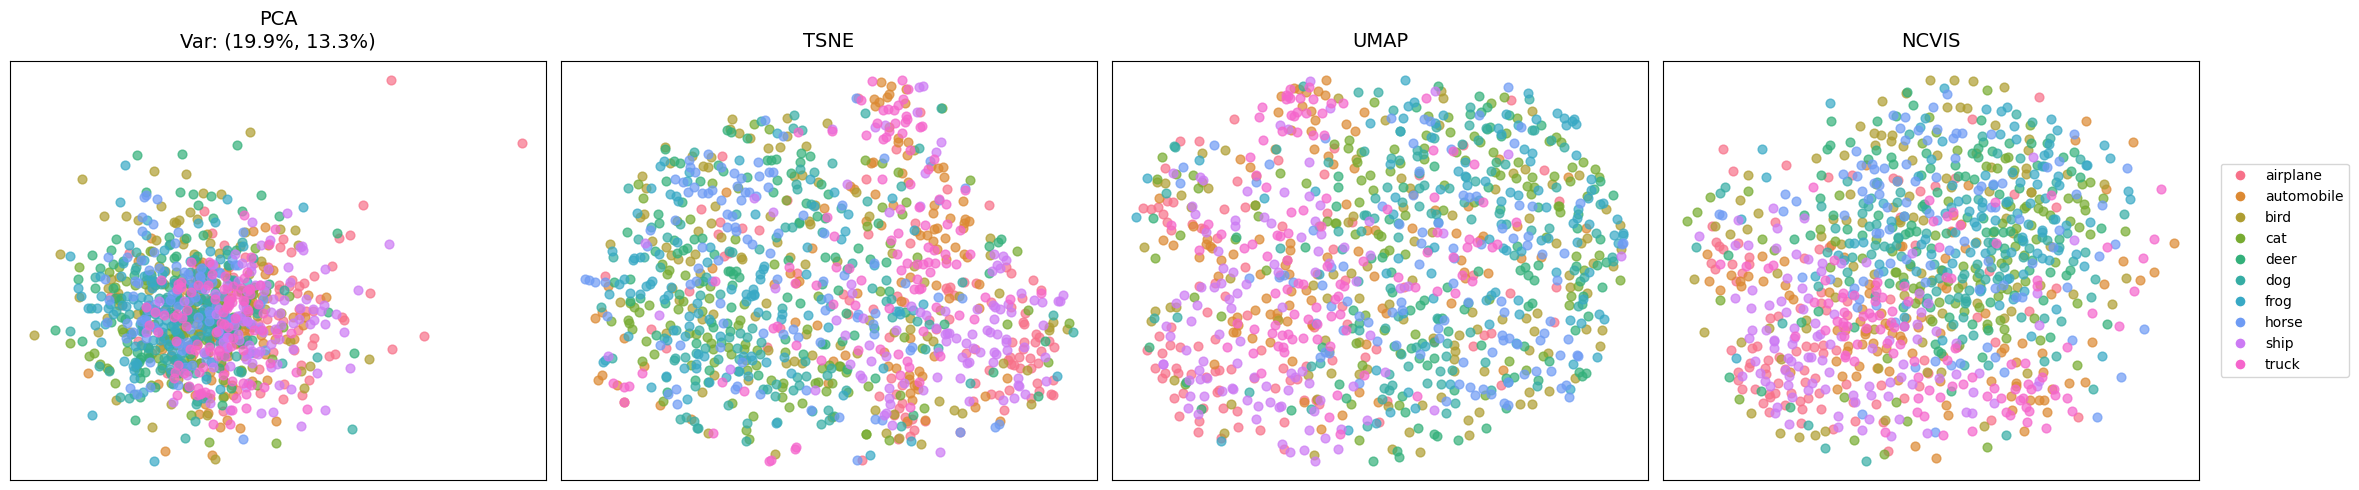

In [9]:
print("Applying dimensionality reduction to DeepInfoMax embeddings...")
dim_fig, dim_reduced, dim_times, _, _ = reduce_and_plot_embeddings(
    dim_embeddings, dim_metadata_df, split='train', save_dir="dim_viz_results"
)

Applying dimensionality reduction to AE embeddings...

Applying PCA...
PCA took 0.00 seconds

Applying TSNE...
TSNE took 5.16 seconds

Applying UMAP...


/home/jovyan/.mlspace/envs/dim3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/.mlspace/envs/dim3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP took 2.03 seconds

Applying NCVIS...
NCVIS took 28.74 seconds


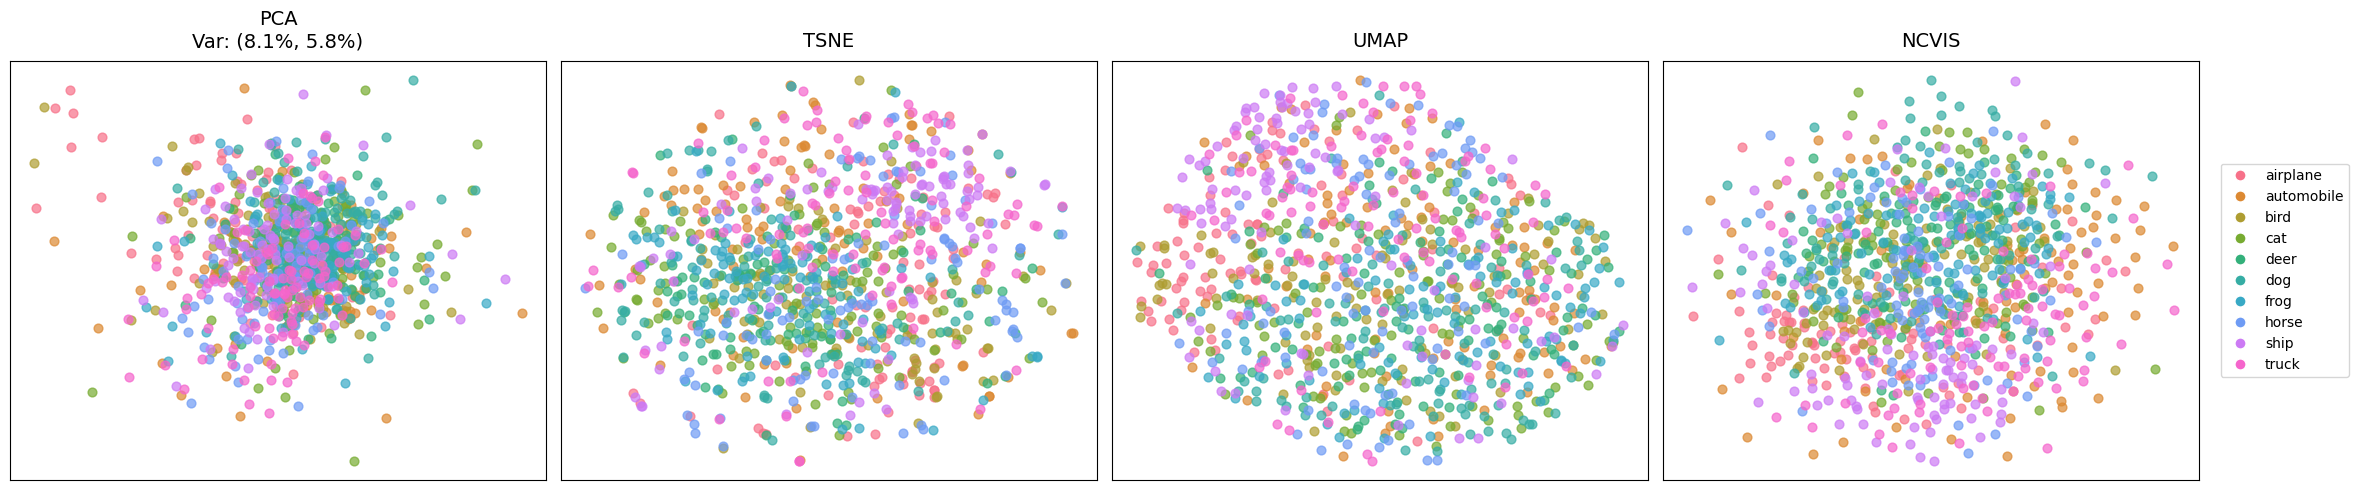

In [10]:
print("Applying dimensionality reduction to AE embeddings...")
ae_fig, ae_reduced, ae_times, _, _ = reduce_and_plot_embeddings(
    ae_embeddings, ae_metadata_df, split='train', save_dir="ae_viz_results"
)